This notebook contains the code for recreating the plots and the statistics for analysis of missense mutations in the ligand-binding region of NOTCH1 in normal skin and oesophagus after deduplicating the mutations (only counting mutations with the same chromosome, position and alternate nucleotide once).   

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

In [2]:
from darwinian_shift import DarwinianShift, GlobalKmerSpectrum
from darwinian_shift import CDFMonteCarloTest, BinomTest
from darwinian_shift import FoldXLookup, SequenceDistanceLookup, MutationExclusionLookup, StructureDistanceLookup
from darwinian_shift import MutationExclusionLookup, ORLookup
from darwinian_shift import hide_top_and_right_axes
from darwinian_shift import plot_scatter_two_scores

/Users/mh28/miniconda3/envs/dsenv3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mh28/miniconda3/envs/dsenv3/lib/python3.8/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


# Setup

In [3]:
# Define the region to test
notch1_section_definition_egf11_12 = {
    'transcript_id': 'ENST00000277541', 'pdb_id': '2vj3', 'pdb_chain': 'A', 
    'start': 412, 'end': 488, # Restrict to the residues in EGF11-12
    'interface_residues': [413, 415, 418, 420, 421, 422, 423, 424, 425, 
                         435, 436, 444, 447, 448, 450, 451, 452, 454, 
                         466, 467, 468, 469, 470, 471, 475, 477, 478, 
                         479, 480],   # defined in Luca et al 2017
    'ca_binding_residues': [412, 413, 415, 431, 432, 435, 452, 453, 455, 469, 470]  # Defined by MetalPDB
}

In [4]:
d_skin = DarwinianShift(
    data = pd.read_excel('248092_3_supp_6645104_q35h43.xlsx', sheet_name='Table S4', skiprows=4),
    source_genome='GRCh37',
    spectra=['skin_trinuc_spectrum.txt', GlobalKmerSpectrum(deduplicate_spectrum=True, name='dedup')],
    included_mutation_types='missense', 
    deduplicate=True,   # Only count each mutation once
)

In [5]:
d_oe = DarwinianShift(
    data=pd.read_excel('aau3879_TableS2.xlsx',
                       sheet_name='Mutations_collapsed_by_distance', skiprows=17),
    source_genome='GRCh37',
    spectra=['oesophagus_trinuc_spectrum.txt', GlobalKmerSpectrum(deduplicate_spectrum=True, name='dedup')],
    included_mutation_types='missense',
    deduplicate=True,   # Only count each mutation once
)

In [6]:
# Directories
sifts_directory="SIFTS_files"
pdb_directory = "PDB_files"

# Colours
unobserved_colour = '#BBBBBB'  
observed_colour = '#EE7733'
foldx_expected_colour = '#EE6677'
foldx_expected_colour_full_spectrum = '#fcbba1'
foldx_observed_colour = '#CC3311'
interface_expected_colour_full_spectrum = '#DBEDFF'
interface_expected_colour = '#88CCEE'
interface_observed_colour = '#0077BB'
calcium_expected_colour_full_spectrum = '#E7F9F3'
calcium_expected_colour = '#8DE0D7'
calcium_observed_colour = '#009988'

# Toy example

In [7]:
# Create some fake data from the real data
# Get some NOTCH1 mutations from EGF11-12 
# Remove hotspots, so we just have our own example to add. 
example_mutations = d_oe.data[(d_oe.data['gene'] == 'NOTCH1') & (d_oe.data['pos'] >= 139411815) & 
                              (d_oe.data['pos'] <= 139412610) & 
                       (d_oe.data['impact'] == 'Missense')].drop_duplicates(subset=['chr', 'pos', 'ref', 'mut'])

# Take 75 mutations at random
example_mutations = example_mutations.sample(n=75, replace=False, random_state=0, axis=0)

# Duplicate a single mutation so it appears 25 times
hotspot = example_mutations.sample(n=1, random_state=1, axis=0)
example_mutations = pd.concat([example_mutations] +[hotspot]*24)

In [8]:
# Make some fake scores
class DummyScores:
    # Score each unique mutation. 
    # Will make sure the score is consistent for the two tests. 
    # Set up using the null mutations for the region.
    def __init__(self, null_data, name='Dummy Values'):
        self.null_data = null_data
        self.null_data['score'] = np.random.random(len(self.null_data))
        self.name = name  # Will appear on some plot axes

    def __call__(self, seq_object):
        return self._get_scores(seq_object.null_mutations, seq_object.chrom)

    def _get_scores(self, df, chrom):
        merged_df = pd.merge(df, self.null_data,
                             on=['pos', 'ref', 'mut'], how='left')
        return merged_df['score']

In [9]:
d_example = DarwinianShift(
    data=example_mutations, 
    source_genome='GRCh37',
    spectra='oesophagus_trinuc_spectrum.txt',  # Use the precalculated spectra from the full oesophagus data set
    statistics=CDFMonteCarloTest(num_draws=100000),
    included_mutation_types='missense'
)

In [10]:
# Need to generate a random score for each mutation.
# First generate all possible mutations in the region
section_for_null = d_example.make_section(notch1_section_definition_egf11_12)
section_for_null.load_section_mutations()

# Then generate the random scores for each possible mutation.
np.random.seed(0)
random_score_generator = DummyScores(section_for_null.null_mutations)

In [11]:
s_example = d_example.run_section(notch1_section_definition_egf11_12, lookup=random_score_generator)

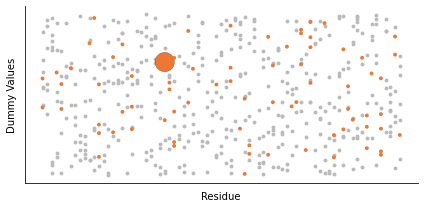

In [12]:
s_example.plot_scatter(figsize=(6, 3), show_legend=False, 
                    unobserved_mutation_colour=unobserved_colour, 
                    missense_mutation_colour=observed_colour, 
                    unmutated_marker_size=15, base_marker_size=15,
                   )
hide_top_and_right_axes()
plt.xticks([])
plt.yticks([])
plt.tight_layout()

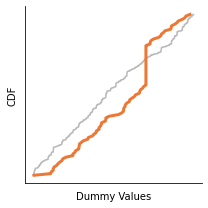

In [13]:
s_example.plot_cdfs(figsize=(3, 3), colours=[observed_colour, unobserved_colour], show_legend=False, show_CI=False)
hide_top_and_right_axes()
plt.ylabel('CDF')
plt.xticks([])
plt.yticks([])
plt.tight_layout()

In [14]:
s_example.get_results_dictionary()

{'gene': 'NOTCH1',
 'transcript_id': 'ENST00000277541',
 'chrom': '9',
 'section_id': '2vj3:A',
 'num_mutations': 99,
 'observed_median': 0.6399210213275238,
 'observed_mean': 0.5594944553444312,
 'expected_median_glob_k3': 0.45615033221654855,
 'median_shift_glob_k3': 0.18377068911097527,
 'expected_mean_glob_k3': 0.48005384869026946,
 'mean_shift_glob_k3': 0.07944060665416175,
 'CDF_MC_glob_k3_num_smaller_or_equal': 99778,
 'CDF_MC_glob_k3_num_larger_or_equal': 224,
 'CDF_MC_glob_k3_pvalue': 0.004479955200447996,
 'CDF_MC_glob_k3_cdf_mean': 0.5822155649303664}

In [15]:
d_example_dedup = DarwinianShift(
    data=example_mutations, 
    source_genome='GRCh37',
    spectra='oesophagus_trinuc_spectrum.txt',  # Use the precalculated spectra from the full oesophagus data set
    statistics=CDFMonteCarloTest(num_draws=100000),
    included_mutation_types='missense', 
    deduplicate=True, 
)

In [16]:
s_example_dedup = d_example_dedup.run_section(notch1_section_definition_egf11_12, lookup=random_score_generator)

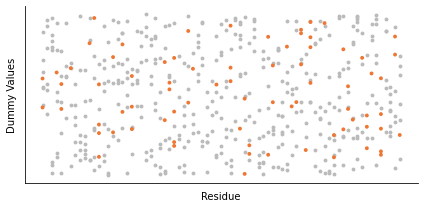

In [17]:
s_example_dedup.plot_scatter(figsize=(6, 3), show_legend=False, 
                    unobserved_mutation_colour=unobserved_colour, 
                    missense_mutation_colour=observed_colour, 
                    unmutated_marker_size=15, base_marker_size=15,
                   )
hide_top_and_right_axes()
plt.xticks([])
plt.yticks([])
plt.tight_layout()

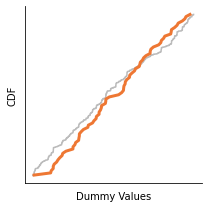

In [18]:
s_example_dedup.plot_cdfs(figsize=(3, 3), 
                          colours=[observed_colour, unobserved_colour], show_legend=False, show_CI=False)
hide_top_and_right_axes()
plt.ylabel('CDF')
plt.xticks([])
plt.yticks([])
plt.tight_layout()

In [19]:
s_example_dedup.get_results_dictionary()

{'gene': 'NOTCH1',
 'transcript_id': 'ENST00000277541',
 'chrom': '9',
 'section_id': '2vj3:A',
 'num_mutations': 75,
 'observed_median': 0.5356328030249583,
 'observed_mean': 0.5131200724391187,
 'expected_median_glob_k3': 0.45615033221654855,
 'median_shift_glob_k3': 0.07948247080840976,
 'expected_mean_glob_k3': 0.48005384869026946,
 'mean_shift_glob_k3': 0.033066223748849266,
 'CDF_MC_glob_k3_num_smaller_or_equal': 84807,
 'CDF_MC_glob_k3_num_larger_or_equal': 15196,
 'CDF_MC_glob_k3_pvalue': 0.3039169608303917,
 'CDF_MC_glob_k3_cdf_mean': 0.5346253176777739}

# Define the metrics

## Individual metrics

In [20]:
# Define the FoldX lookup
fold = FoldXLookup(foldx_results_directory="FoldX_results",
                   sifts_directory=sifts_directory,
                   foldx_file_name_start="PS_f*", download_sifts=True)

In [21]:
# Define a lookup object which determines whether mutations are on the NOTCH1-ligand interface. 
interface_lookup = SequenceDistanceLookup(
    boolean=True,   # Just a boolean on/off interface. 
    target_key='interface_residues',   # Use this entry in the section_definition dict to define the target residues
    position_type='residue',   # Use the residue number (as opposed to cdspos or chromosomal position)
    name='On interface'  # Label to appear on plot axes
)

In [22]:
ca_lookup = SequenceDistanceLookup(
    boolean=True,   # Just a boolean binding/not binding. 
    target_key='ca_binding_residues',   # Use this entry in the section_definition dict to define the target residues
    position_type='residue',   # Use the residue number (as opposed to cdspos or chromosomal position)
    name='Calcium binding'  # Label to appear on plot axes
)

## Conditional tests 

In [23]:
# First define a lookup that is 1 if the mutation is on the interface and or calcium binding
interface_or_ca_lookup = ORLookup(
    lookups=[interface_lookup, ca_lookup],  
    thresholds=[0.5, 0.5],  # Set thresholds at 0.5
    directions=[1, 1],  # Want to exclude mutations which score 1 for interface or calcium binding.
)


# Define the combined lookup.
excllook_foldx = MutationExclusionLookup(
    lookup=fold,   # Use the calcium binding lookup for the test
    exclusion_lookup=interface_or_ca_lookup,
    exclusion_threshold=0.5,  #  Scores from the exclusion are either 0, or 1, so can put threshold anywhere in between.
    exclusion_direction=1,   # Exclude mutations with a score above the exclusion_threhold from the exclusion_lookup.
    name=fold.name
)

In [24]:
# First define a lookup that is 1 if the mutation is destabilising or calcium binding
destabilising_or_ca_lookup = ORLookup(
    lookups=[fold, ca_lookup],  
    thresholds=[2, 0.5],  # Use 2kcal/mol as the ∆∆G threshold. Ca score is 0 or 1, so set threshold at 0.5
    directions=[1, 1],  # Want to exclude mutations which score 1 for calcium binding or > 2 for ∆G.
)


# Define the combined lookup.
excllook_interface = MutationExclusionLookup(
    lookup=interface_lookup,   # Use the inteface lookup for the test
    exclusion_lookup=destabilising_or_ca_lookup,   
    exclusion_threshold=0.5,  #  Scores from the exclusion are either 0, or 1, so can put threshold anywhere in between.
    exclusion_direction=1,   # Exclude mutations with a score above the exclusion_threhold from the exclusion_lookup.
    name=interface_lookup.name
)

In [25]:
# First define a lookup that is 1 if the mutation is destabilising or on the interface and 0 otherwise.
destabilising_or_interface_lookup = ORLookup(
    lookups=[fold, interface_lookup],  # Use the FoldX and the interface lookups.  
    thresholds=[2, 0.5],  # Again pick a threshold of 2kcal/mol for the FoldX result, interface results are either 0 or 1 so set threshold at 0.5. 
    directions=[1, 1],  # Want to exclude mutations with scores greater than the thresholds, so directions are both 1.
)


# Define the combined lookup.
excllook_ca = MutationExclusionLookup(
    lookup=ca_lookup,   # Use the calcium binding lookup for the test
    exclusion_lookup=destabilising_or_interface_lookup,   
    exclusion_threshold=0.5,  #  Scores from the exclusion are either 0, or 1, so can put threshold anywhere in between.
    exclusion_direction=1,   # Exclude mutations with a score above the exclusion_threhold from the exclusion_lookup.
    name=ca_lookup.name
)

# Skin

## FoldX

In [26]:
# Exclude the interface and calcium binding mutations from the test
s = d_skin.run_section(notch1_section_definition_egf11_12, lookup=excllook_foldx, 
                     statistics=CDFMonteCarloTest(num_draws=100000))

In [27]:
s.get_results_dictionary()

{'gene': 'NOTCH1',
 'transcript_id': 'ENST00000277541',
 'chrom': '9',
 'section_id': '2vj3:A',
 'num_mutations': 113,
 'observed_median': 4.10174,
 'observed_mean': 5.997173185840708,
 'expected_median_glob_k3': 0.85534,
 'median_shift_glob_k3': 3.2464000000000004,
 'expected_mean_glob_k3': 2.2953249579660078,
 'mean_shift_glob_k3': 3.7018482278747005,
 'CDF_MC_glob_k3_num_smaller_or_equal': 100001,
 'CDF_MC_glob_k3_num_larger_or_equal': 1,
 'CDF_MC_glob_k3_pvalue': 1.999980000199998e-05,
 'CDF_MC_glob_k3_cdf_mean': 0.740941739299,
 'expected_median_dedup': 1.06148,
 'median_shift_dedup': 3.0402600000000004,
 'expected_mean_dedup': 2.6526179632508353,
 'mean_shift_dedup': 3.344555222589873,
 'CDF_MC_dedup_num_smaller_or_equal': 100001,
 'CDF_MC_dedup_num_larger_or_equal': 1,
 'CDF_MC_dedup_pvalue': 1.999980000199998e-05,
 'CDF_MC_dedup_cdf_mean': 0.7137990499556645}

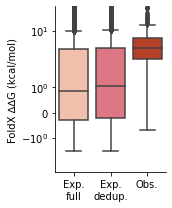

In [28]:
s.plot_boxplot(figsize=(2.5, 3), plot_scale='symlog', 
                    colours=[foldx_observed_colour, foldx_expected_colour_full_spectrum, 
                             foldx_expected_colour])
plt.xticks(range(3), ['Exp.\nfull', 'Exp.\ndedup.', 'Obs.'])
hide_top_and_right_axes()
plt.tight_layout()

## Interface

In [29]:
# Exclude the high ∆∆G and calcium binding mutations from the test
s = d_skin.run_section(notch1_section_definition_egf11_12, lookup=excllook_interface, 
                    statistics=BinomTest())

In [30]:
s.get_results_dictionary()

{'gene': 'NOTCH1',
 'transcript_id': 'ENST00000277541',
 'chrom': '9',
 'section_id': '2vj3:A',
 'num_mutations': 65,
 'observed_median': 1.0,
 'observed_mean': 0.6307692307692307,
 'expected_median_glob_k3': 0.0,
 'median_shift_glob_k3': 1.0,
 'expected_mean_glob_k3': 0.3947996496593131,
 'mean_shift_glob_k3': 0.23596958110991767,
 'binom_glob_k3_pvalue': 0.00017922709143172228,
 'binom_glob_k3_expected_proportion': 0.39479964965931313,
 'binom_glob_k3_observed_proportion': 0.6307692307692307,
 'binom_glob_k3_expected_count': 25.661977227855353,
 'binom_glob_k3_observed_count': 41,
 'binom_glob_k3_threshold': 0.5,
 'binom_glob_k3_expected_CI_high': 34.0,
 'binom_glob_k3_expected_CI_low': 18.0,
 'binom_glob_k3_observed_CI_low': 33.0,
 'binom_glob_k3_observed_CI_high': 48.0,
 'expected_median_dedup': 0.0,
 'median_shift_dedup': 1.0,
 'expected_mean_dedup': 0.4181743743336176,
 'mean_shift_dedup': 0.21259485643561316,
 'binom_dedup_pvalue': 0.0006161366733427173,
 'binom_dedup_expected_p

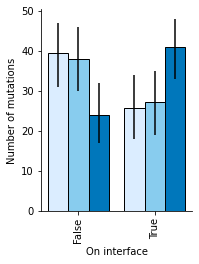

In [31]:
s.plot_binned_counts(figsize=(3, 4), show_legend=False, 
                     colours=[interface_observed_colour, 
                              interface_expected_colour_full_spectrum, 
                              interface_expected_colour], 
                     bins=[-1, 0.5, 1], linewidth=1)
plt.title('')
hide_top_and_right_axes()
plt.xticks(plt.gca().get_xticks(), ['False', 'True'])
plt.xlabel('On interface')
plt.subplots_adjust(left=0.3, bottom=0.3, right=1, top=1)

## CA binding

In [32]:
# Exclude the high ∆∆G and ligand-binding interface mutations from the test
s = d_skin.run_section(notch1_section_definition_egf11_12, lookup=excllook_ca, 
                    statistics=BinomTest())

In [33]:
s.get_results_dictionary()

{'gene': 'NOTCH1',
 'transcript_id': 'ENST00000277541',
 'chrom': '9',
 'section_id': '2vj3:A',
 'num_mutations': 40,
 'observed_median': 0.0,
 'observed_mean': 0.4,
 'expected_median_glob_k3': 0.0,
 'median_shift_glob_k3': 0.0,
 'expected_mean_glob_k3': 0.18461014601780223,
 'mean_shift_glob_k3': 0.2153898539821978,
 'binom_glob_k3_pvalue': 0.0015169198200354619,
 'binom_glob_k3_expected_proportion': 0.18461014601780223,
 'binom_glob_k3_observed_proportion': 0.4,
 'binom_glob_k3_expected_count': 7.384405840712089,
 'binom_glob_k3_observed_count': 16,
 'binom_glob_k3_threshold': 0.5,
 'binom_glob_k3_expected_CI_high': 12.0,
 'binom_glob_k3_expected_CI_low': 3.0,
 'binom_glob_k3_observed_CI_low': 10.0,
 'binom_glob_k3_observed_CI_high': 22.0,
 'expected_median_dedup': 0.0,
 'median_shift_dedup': 0.0,
 'expected_mean_dedup': 0.19627681061156735,
 'mean_shift_dedup': 0.20372318938843267,
 'binom_dedup_pvalue': 0.004126737798692212,
 'binom_dedup_expected_proportion': 0.19627681061156732,


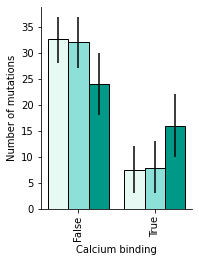

In [34]:
s.plot_binned_counts(figsize=(3, 4), show_legend=False, 
                     colours=[calcium_observed_colour, 
                              calcium_expected_colour_full_spectrum, 
                              calcium_expected_colour], 
                     linewidth=1, bins=[-1, 0.5, 1]
                        )
hide_top_and_right_axes()
plt.title('')
plt.xticks(plt.gca().get_xticks(), ['False', 'True'])
plt.xlabel('Calcium binding')
plt.subplots_adjust(left=0.3, bottom=0.3, right=1, top=1)

# Oesophagus

In [35]:
# Exclude the interface and calcium binding mutations from the test
s = d_oe.run_section(notch1_section_definition_egf11_12, lookup=excllook_foldx, 
                     statistics=CDFMonteCarloTest(num_draws=100000))

In [36]:
s.get_results_dictionary()

{'gene': 'NOTCH1',
 'transcript_id': 'ENST00000277541',
 'chrom': '9',
 'section_id': '2vj3:A',
 'num_mutations': 76,
 'observed_median': 4.1399550000000005,
 'observed_mean': 7.18855957894737,
 'expected_median_glob_k3': 1.92008,
 'median_shift_glob_k3': 2.2198750000000005,
 'expected_mean_glob_k3': 4.684955577673519,
 'mean_shift_glob_k3': 2.5036040012738505,
 'CDF_MC_glob_k3_num_smaller_or_equal': 100001,
 'CDF_MC_glob_k3_num_larger_or_equal': 1,
 'CDF_MC_glob_k3_pvalue': 1.999980000199998e-05,
 'CDF_MC_glob_k3_cdf_mean': 0.670400664338964,
 'expected_median_dedup': 1.23736,
 'median_shift_dedup': 2.9025950000000007,
 'expected_mean_dedup': 4.160194166684001,
 'mean_shift_dedup': 3.0283654122633683,
 'CDF_MC_dedup_num_smaller_or_equal': 100001,
 'CDF_MC_dedup_num_larger_or_equal': 1,
 'CDF_MC_dedup_pvalue': 1.999980000199998e-05,
 'CDF_MC_dedup_cdf_mean': 0.6966391572158637}

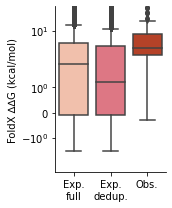

In [37]:
s.plot_boxplot(figsize=(2.5, 3), plot_scale='symlog', 
                    colours=[foldx_observed_colour, foldx_expected_colour_full_spectrum, 
                             foldx_expected_colour])
plt.xticks(range(3), ['Exp.\nfull', 'Exp.\ndedup.', 'Obs.'])
hide_top_and_right_axes()
plt.tight_layout()

## Interface

In [38]:
# Exclude the high ∆∆G and calcium binding mutations from the test
s = d_oe.run_section(notch1_section_definition_egf11_12, lookup=excllook_interface, 
                    statistics=BinomTest())

In [39]:
s.get_results_dictionary()

{'gene': 'NOTCH1',
 'transcript_id': 'ENST00000277541',
 'chrom': '9',
 'section_id': '2vj3:A',
 'num_mutations': 37,
 'observed_median': 1.0,
 'observed_mean': 0.7027027027027027,
 'expected_median_glob_k3': 0.0,
 'median_shift_glob_k3': 1.0,
 'expected_mean_glob_k3': 0.4081390445988698,
 'mean_shift_glob_k3': 0.29456365810383295,
 'binom_glob_k3_pvalue': 0.00034422098156581486,
 'binom_glob_k3_expected_proportion': 0.40813904459886974,
 'binom_glob_k3_observed_proportion': 0.7027027027027027,
 'binom_glob_k3_expected_count': 15.10114465015818,
 'binom_glob_k3_observed_count': 26,
 'binom_glob_k3_threshold': 0.5,
 'binom_glob_k3_expected_CI_high': 21.0,
 'binom_glob_k3_expected_CI_low': 9.0,
 'binom_glob_k3_observed_CI_low': 20.0,
 'binom_glob_k3_observed_CI_high': 31.0,
 'expected_median_dedup': 0.0,
 'median_shift_dedup': 1.0,
 'expected_mean_dedup': 0.4025804354850389,
 'mean_shift_dedup': 0.30012226721766383,
 'binom_dedup_pvalue': 0.00029987954553930966,
 'binom_dedup_expected_pr

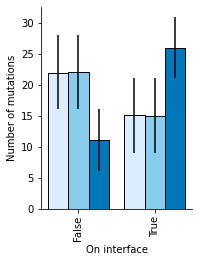

In [40]:
s.plot_binned_counts(figsize=(3, 4), show_legend=False, 
                     colours=[interface_observed_colour, 
                              interface_expected_colour_full_spectrum, 
                              interface_expected_colour], 
                     bins=[-1, 0.5, 1], linewidth=1)
plt.title('')
hide_top_and_right_axes()
plt.xticks(plt.gca().get_xticks(), ['False', 'True'])
plt.xlabel('On interface')
plt.subplots_adjust(left=0.3, bottom=0.3, right=1, top=1)

## CA binding

In [41]:
# Exclude the high ∆∆G and ligand-binding interface mutations from the test
s = d_oe.run_section(notch1_section_definition_egf11_12, lookup=excllook_ca, 
                    statistics=BinomTest())

In [42]:
s.get_results_dictionary()

{'gene': 'NOTCH1',
 'transcript_id': 'ENST00000277541',
 'chrom': '9',
 'section_id': '2vj3:A',
 'num_mutations': 20,
 'observed_median': 0.0,
 'observed_mean': 0.45,
 'expected_median_glob_k3': 0.0,
 'median_shift_glob_k3': 0.0,
 'expected_mean_glob_k3': 0.1975591904274036,
 'mean_shift_glob_k3': 0.2524408095725964,
 'binom_glob_k3_pvalue': 0.009196042775008495,
 'binom_glob_k3_expected_proportion': 0.1975591904274036,
 'binom_glob_k3_observed_proportion': 0.45,
 'binom_glob_k3_expected_count': 3.9511838085480724,
 'binom_glob_k3_observed_count': 9,
 'binom_glob_k3_threshold': 0.5,
 'binom_glob_k3_expected_CI_high': 8.0,
 'binom_glob_k3_expected_CI_low': 1.0,
 'binom_glob_k3_observed_CI_low': 5.0,
 'binom_glob_k3_observed_CI_high': 13.0,
 'expected_median_dedup': 0.0,
 'median_shift_dedup': 0.0,
 'expected_mean_dedup': 0.2014140029696676,
 'mean_shift_dedup': 0.2485859970303324,
 'binom_dedup_pvalue': 0.010460616822099467,
 'binom_dedup_expected_proportion': 0.2014140029696676,
 'bino

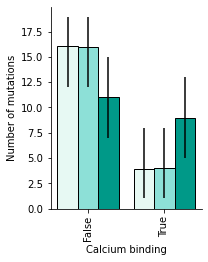

In [43]:
s.plot_binned_counts(figsize=(3, 4), show_legend=False, 
                     colours=[calcium_observed_colour, 
                              calcium_expected_colour_full_spectrum, 
                              calcium_expected_colour], 
                     linewidth=1, bins=[-1, 0.5, 1]
                        )
hide_top_and_right_axes()
plt.title('')
plt.xticks(plt.gca().get_xticks(), ['False', 'True'])
plt.xlabel('Calcium binding')
plt.subplots_adjust(left=0.3, bottom=0.3, right=1, top=1)